In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 8.6 MB/s 
     |████████████████████████████████| 482 kB 47.5 MB/s 
     |████████████████████████████████| 462 kB 40.0 MB/s 
     |████████████████████████████████| 41 kB 333 kB/s 


In [ ]:
pip install ogb

     |████████████████████████████████| 78 kB 3.3 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=46266d72cbd3b26917315a19eb622d02252ad00238a61a470707c4dc52ff97e0
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [ ]:
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from ogb.graphproppred import GraphPropPredDataset
dataset = GraphPropPredDataset(name = 'ogbg-molhiv')

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:01<00:00, 22428.54it/s]


Saving...


#Create list of StellarGraph instances

In [ ]:
graphs = []
for i in range(len(dataset)):

  feat_names = ["".join(["col", str(j)]) for j in range(dataset.graphs[0]["node_feat"].shape[1])]
  nodes = pd.DataFrame(dataset.graphs[i]["node_feat"], columns=feat_names)
  nodes["node_id"] = range(dataset.graphs[i]["node_feat"].shape[0])

  feat_names = ["".join(["col", str(j)]) for j in range(dataset.graphs[0]["edge_feat"].shape[1])]
  edges = pd.DataFrame(dataset.graphs[i]["edge_feat"], columns=feat_names)
  edges["edge_id"] = range(dataset.graphs[i]["edge_feat"].shape[0])
  edges.insert(0, "source", dataset.graphs[i]["edge_index"][0])
  edges.insert(1, "target", dataset.graphs[i]["edge_index"][1])

  stelG = StellarGraph(nodes, edges)
  graphs.append(stelG)
  if i % 100 == 0:
    print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [ ]:
graphs[0].info()

'StellarGraph: Undirected multigraph\n Nodes: 21, Edges: 48\n\n Node types:\n  default: [21]\n    Features: float32 vector, length 10\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [48]\n        Weights: all 1 (default)\n        Features: float32 vector, length 4'

#Prepare data for training and validation

In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)

In [ ]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_idx),
    targets=dataset.labels[train_idx],
    batch_size=256,
    symmetric_normalization=False,
)

valid_gen = gen.flow(
    list(valid_idx),
    targets=dataset.labels[valid_idx],
    batch_size=1,
    symmetric_normalization=False,
)

#Model with 4 GCN layers, 2 convolution layers and 1 dense layer

In [ ]:
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k = 35,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model4dgcnn = Model(inputs=x_inp, outputs=predictions)

model4dgcnn.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc", "AUC"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model4dgcnn.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, None, 10)]   0           []                               
                                                                                                  
 dropout_66 (Dropout)           (None, None, 10)     0           ['input_40[0][0]']               
                                                                                                  
 input_42 (InputLayer)          [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution_50 (GraphCon  (None, None, 32)    320         ['dropout_66[0][0]',      

In [ ]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=10,
    verbose=0,
    restore_best_weights=True
)

In [ ]:
history4dgcnn = model4dgcnn.fit(
    train_gen, epochs=100, verbose=1, validation_data=valid_gen, shuffle=True, callbacks=[cb])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_11/sort_pooling_14/map/while/gradients/model_11/sort_pooling_14/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_11/sort_pooling_14/map/while/gradients/model_11/sort_pooling_14/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_11/sort_pooling_14/map/while/gradients/model_11/sort_pooling_14/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


129/129 [==============================] - 35s 254ms/step - loss: 0.2565 - acc: 0.9344 - auc: 0.4738 - val_loss: 0.1022 - val_acc: 0.9803 - val_auc: 0.6346
Epoch 2/100
129/129 [==============================] - 32s 249ms/step - loss: 0.1671 - acc: 0.9626 - auc: 0.5549 - val_loss: 0.1028 - val_acc: 0.9803 - val_auc: 0.6395
Epoch 3/100
129/129 [==============================] - 32s 249ms/step - loss: 0.1625 - acc: 0.9626 - auc: 0.5853 - val_loss: 0.0998 - val_acc: 0.9803 - val_auc: 0.6302
Epoch 4/100
129/129 [==============================] - 34s 261ms/step - loss: 0.1620 - acc: 0.9626 - auc: 0.5794 - val_loss: 0.0985 - val_acc: 0.9803 - val_auc: 0.6339
Epoch 5/100
129/129 [==============================] - 32s 248ms/step - loss: 0.1607 - acc: 0.9626 - auc: 0.5833 - val_loss: 0.1163 - val_acc: 0.9803 - val_auc: 0.6513
Epoch 6/100
129/129 [==============================] - 32s 249ms/step - loss: 0.1596 - acc: 0.9626 - auc: 0.5963 - val_loss: 0.1155 - val_acc: 0.9803 - val_auc: 0.6652
Epoc

In [ ]:
model4dgcnn.evaluate(valid_gen)

4113/4113 [==============================] - 11s 3ms/step - loss: 0.1032 - acc: 0.9803 - auc: 0.7372


[0.10322577506303787, 0.9803063273429871, 0.737167477607727]

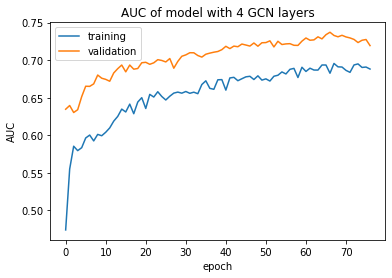

In [ ]:
plt.plot(history4dgcnn.history['auc'])
plt.plot(history4dgcnn.history['val_auc'])
plt.title('AUC of model with 4 GCN layers')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

#Model with 3 GCN layers

In [ ]:
layer_sizes = [32, 16, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh"],
    k=35,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model3dgcnn = Model(inputs=x_inp, outputs=predictions)

model3dgcnn.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc", "AUC"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model3dgcnn.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, None, 10)]   0           []                               
                                                                                                  
 dropout_62 (Dropout)           (None, None, 10)     0           ['input_37[0][0]']               
                                                                                                  
 input_39 (InputLayer)          [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution_47 (GraphCon  (None, None, 32)    320         ['dropout_62[0][0]',      

In [ ]:
history3dgcnn = model3dgcnn.fit(
    train_gen, epochs=100, verbose=1, validation_data=valid_gen, shuffle=True, callbacks=[cb])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_10/sort_pooling_13/map/while/gradients/model_10/sort_pooling_13/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_10/sort_pooling_13/map/while/gradients/model_10/sort_pooling_13/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_10/sort_pooling_13/map/while/gradients/model_10/sort_pooling_13/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


129/129 [==============================] - 30s 222ms/step - loss: 0.2391 - acc: 0.9560 - auc: 0.4791 - val_loss: 0.1055 - val_acc: 0.9803 - val_auc: 0.6281
Epoch 2/100
129/129 [==============================] - 28s 218ms/step - loss: 0.1649 - acc: 0.9626 - auc: 0.5590 - val_loss: 0.0996 - val_acc: 0.9803 - val_auc: 0.6353
Epoch 3/100
129/129 [==============================] - 28s 218ms/step - loss: 0.1605 - acc: 0.9626 - auc: 0.5946 - val_loss: 0.0962 - val_acc: 0.9803 - val_auc: 0.6316
Epoch 4/100
129/129 [==============================] - 28s 218ms/step - loss: 0.1601 - acc: 0.9626 - auc: 0.5938 - val_loss: 0.1006 - val_acc: 0.9803 - val_auc: 0.6435
Epoch 5/100
129/129 [==============================] - 28s 217ms/step - loss: 0.1584 - acc: 0.9626 - auc: 0.6071 - val_loss: 0.0947 - val_acc: 0.9803 - val_auc: 0.6442
Epoch 6/100
129/129 [==============================] - 28s 218ms/step - loss: 0.1582 - acc: 0.9626 - auc: 0.6138 - val_loss: 0.0944 - val_acc: 0.9803 - val_auc: 0.6563
Epoc

In [ ]:
model3dgcnn.evaluate(valid_gen)

4113/4113 [==============================] - 11s 3ms/step - loss: 0.1107 - acc: 0.9808 - auc: 0.7016


[0.11073081195354462, 0.9807925820350647, 0.7016185522079468]

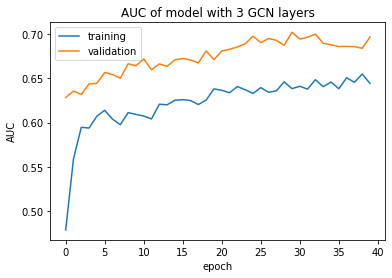

In [ ]:
plt.plot(history3dgcnn.history['auc'])
plt.plot(history3dgcnn.history['val_auc'])
plt.title('AUC of model with 3 GCN layers')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

#Model with 5 GCN layers

In [ ]:
layer_sizes = [64, 64, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh", "tanh"],
    k=35,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model5dgcnn = Model(inputs=x_inp, outputs=predictions)

model5dgcnn.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc", "AUC"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model5dgcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 dropout_6 (Dropout)            (None, None, 10)     0           ['input_4[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution_5 (GraphConv  (None, None, 64)    640         ['dropout_6[0][0]',        

In [ ]:
history5dgcnn = model5dgcnn.fit(
    train_gen, epochs=100, verbose=1, validation_data=valid_gen, shuffle=True, callbacks=[cb])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/sort_pooling_1/map/while/gradients/model_1/sort_pooling_1/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/sort_pooling_1/map/while/gradients/model_1/sort_pooling_1/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/sort_pooling_1/map/while/gradients/model_1/sort_pooling_1/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


129/129 [==============================] - 46s 342ms/step - loss: 0.2249 - acc: 0.9604 - auc: 0.4612 - val_loss: 0.0995 - val_acc: 0.9803 - val_auc: 0.6238
Epoch 2/100
129/129 [==============================] - 44s 340ms/step - loss: 0.1676 - acc: 0.9626 - auc: 0.5514 - val_loss: 0.0940 - val_acc: 0.9803 - val_auc: 0.6467
Epoch 3/100
129/129 [==============================] - 44s 339ms/step - loss: 0.1639 - acc: 0.9626 - auc: 0.5688 - val_loss: 0.0999 - val_acc: 0.9803 - val_auc: 0.6487
Epoch 4/100
129/129 [==============================] - 43s 336ms/step - loss: 0.1615 - acc: 0.9626 - auc: 0.5811 - val_loss: 0.0964 - val_acc: 0.9803 - val_auc: 0.6592
Epoch 5/100
129/129 [==============================] - 43s 333ms/step - loss: 0.1625 - acc: 0.9626 - auc: 0.5846 - val_loss: 0.0979 - val_acc: 0.9803 - val_auc: 0.6599
Epoch 6/100
129/129 [==============================] - 43s 330ms/step - loss: 0.1592 - acc: 0.9626 - auc: 0.5962 - val_loss: 0.1130 - val_acc: 0.9803 - val_auc: 0.6600
Epoc

In [ ]:
model5dgcnn.evaluate(valid_gen)

4113/4113 [==============================] - 12s 3ms/step - loss: 0.0913 - acc: 0.9796 - auc: 0.7505


[0.09131135791540146, 0.9795769453048706, 0.7505221366882324]

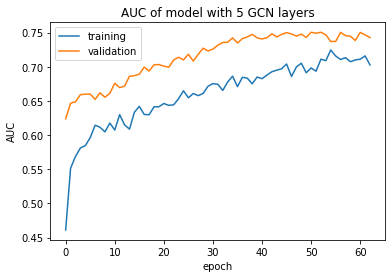

In [ ]:
plt.plot(history5dgcnn.history['auc'])
plt.plot(history5dgcnn.history['val_auc'])
plt.title('AUC of model with 5 GCN layers')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

#Model with 2 dense layers

In [ ]:
layer_sizes = [64, 64, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh", "tanh"],
    k=35,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)
x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model2dense = Model(inputs=x_inp, outputs=predictions)

model2dense.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc", "AUC"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model2dense.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, None, 10)]   0           []                               
                                                                                                  
 dropout_77 (Dropout)           (None, None, 10)     0           ['input_46[0][0]']               
                                                                                                  
 input_48 (InputLayer)          [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution_59 (GraphCon  (None, None, 64)    640         ['dropout_77[0][0]',      

In [ ]:
history2dense = model2dense.fit(
    train_gen, epochs=100, verbose=1, validation_data=valid_gen, shuffle=True, callbacks=[cb])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_13/sort_pooling_16/map/while/gradients/model_13/sort_pooling_16/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_13/sort_pooling_16/map/while/gradients/model_13/sort_pooling_16/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_13/sort_pooling_16/map/while/gradients/model_13/sort_pooling_16/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


129/129 [==============================] - 47s 345ms/step - loss: 0.2838 - acc: 0.9160 - auc: 0.5130 - val_loss: 0.1010 - val_acc: 0.9803 - val_auc: 0.6173
Epoch 2/100
129/129 [==============================] - 43s 336ms/step - loss: 0.1767 - acc: 0.9625 - auc: 0.5480 - val_loss: 0.1063 - val_acc: 0.9803 - val_auc: 0.6431
Epoch 3/100
129/129 [==============================] - 44s 341ms/step - loss: 0.1704 - acc: 0.9626 - auc: 0.5751 - val_loss: 0.0938 - val_acc: 0.9803 - val_auc: 0.6480
Epoch 4/100
129/129 [==============================] - 44s 341ms/step - loss: 0.1694 - acc: 0.9626 - auc: 0.5669 - val_loss: 0.1021 - val_acc: 0.9803 - val_auc: 0.6431
Epoch 5/100
129/129 [==============================] - 42s 324ms/step - loss: 0.1671 - acc: 0.9626 - auc: 0.5814 - val_loss: 0.0948 - val_acc: 0.9803 - val_auc: 0.6398
Epoch 6/100
129/129 [==============================] - 44s 340ms/step - loss: 0.1650 - acc: 0.9626 - auc: 0.5850 - val_loss: 0.1053 - val_acc: 0.9803 - val_auc: 0.6377
Epoc

In [ ]:
model2dense.evaluate(valid_gen)

4113/4113 [==============================] - 11s 3ms/step - loss: 0.1045 - acc: 0.9803 - auc: 0.7355


[0.10454890131950378, 0.9803063273429871, 0.7354696393013]

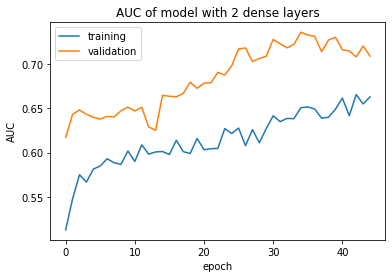

In [ ]:
plt.plot(history2dense.history['auc'])
plt.plot(history2dense.history['val_auc'])
plt.title('AUC of model with 2 dense layers')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

#Model with 3 dense layers

In [ ]:
layer_sizes = [64, 64, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh", "tanh"],
    k=35,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)
x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)
x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model3dense = Model(inputs=x_inp, outputs=predictions)

model3dense.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc", "AUC"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model3dense.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, None, 10)]   0           []                               
                                                                                                  
 dropout_84 (Dropout)           (None, None, 10)     0           ['input_49[0][0]']               
                                                                                                  
 input_51 (InputLayer)          [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution_64 (GraphCon  (None, None, 64)    640         ['dropout_84[0][0]',      

In [ ]:
history3dense = model3dense.fit(
    train_gen, epochs=100, verbose=1, validation_data=valid_gen, shuffle=True, callbacks=[cb])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_14/sort_pooling_17/map/while/gradients/model_14/sort_pooling_17/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_14/sort_pooling_17/map/while/gradients/model_14/sort_pooling_17/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_14/sort_pooling_17/map/while/gradients/model_14/sort_pooling_17/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


129/129 [==============================] - 47s 344ms/step - loss: 0.2792 - acc: 0.9253 - auc: 0.4956 - val_loss: 0.1191 - val_acc: 0.9803 - val_auc: 0.6447
Epoch 2/100
129/129 [==============================] - 43s 332ms/step - loss: 0.1797 - acc: 0.9624 - auc: 0.5813 - val_loss: 0.1174 - val_acc: 0.9803 - val_auc: 0.6636
Epoch 3/100
129/129 [==============================] - 44s 339ms/step - loss: 0.1745 - acc: 0.9625 - auc: 0.5787 - val_loss: 0.1254 - val_acc: 0.9803 - val_auc: 0.6703
Epoch 4/100
129/129 [==============================] - 44s 341ms/step - loss: 0.1717 - acc: 0.9626 - auc: 0.5850 - val_loss: 0.1050 - val_acc: 0.9803 - val_auc: 0.6716
Epoch 5/100
129/129 [==============================] - 44s 341ms/step - loss: 0.1709 - acc: 0.9626 - auc: 0.5811 - val_loss: 0.1292 - val_acc: 0.9803 - val_auc: 0.6707
Epoch 6/100
129/129 [==============================] - 44s 341ms/step - loss: 0.1672 - acc: 0.9626 - auc: 0.5999 - val_loss: 0.1218 - val_acc: 0.9803 - val_auc: 0.6717
Epoc

In [ ]:
model3dense.evaluate(valid_gen)

4113/4113 [==============================] - 11s 3ms/step - loss: 0.1021 - acc: 0.9803 - auc: 0.7482


[0.10211847722530365, 0.9803063273429871, 0.7481659650802612]

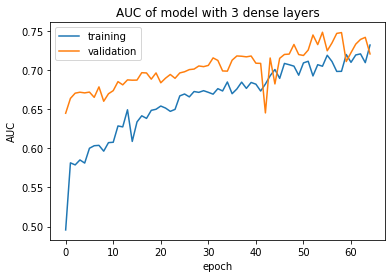

In [ ]:
plt.plot(history3dense.history['auc'])
plt.plot(history3dense.history['val_auc'])
plt.title('AUC of model with 3 dense layers')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

#Model with 1 convolution layer

In [ ]:
layer_sizes = [64, 64, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh", "tanh"],
    k=35,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model1conv = Model(inputs=x_inp, outputs=predictions)

model1conv.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc", "AUC"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model1conv.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, None, 10)]   0           []                               
                                                                                                  
 dropout_92 (Dropout)           (None, None, 10)     0           ['input_52[0][0]']               
                                                                                                  
 input_54 (InputLayer)          [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution_69 (GraphCon  (None, None, 64)    640         ['dropout_92[0][0]',      

In [ ]:
history1conv = model1conv.fit(
    train_gen, epochs=100, verbose=1, validation_data=valid_gen, shuffle=True, callbacks=[cb])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_15/sort_pooling_18/map/while/gradients/model_15/sort_pooling_18/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_15/sort_pooling_18/map/while/gradients/model_15/sort_pooling_18/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_15/sort_pooling_18/map/while/gradients/model_15/sort_pooling_18/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


129/129 [==============================] - 46s 339ms/step - loss: 0.2205 - acc: 0.9476 - auc: 0.5006 - val_loss: 0.0994 - val_acc: 0.9803 - val_auc: 0.6298
Epoch 2/100
129/129 [==============================] - 44s 340ms/step - loss: 0.1621 - acc: 0.9626 - auc: 0.5763 - val_loss: 0.0971 - val_acc: 0.9803 - val_auc: 0.6543
Epoch 3/100
129/129 [==============================] - 43s 334ms/step - loss: 0.1606 - acc: 0.9626 - auc: 0.5858 - val_loss: 0.1022 - val_acc: 0.9803 - val_auc: 0.6655
Epoch 4/100
129/129 [==============================] - 43s 335ms/step - loss: 0.1592 - acc: 0.9626 - auc: 0.5979 - val_loss: 0.0989 - val_acc: 0.9803 - val_auc: 0.6674
Epoch 5/100
129/129 [==============================] - 41s 321ms/step - loss: 0.1584 - acc: 0.9626 - auc: 0.6089 - val_loss: 0.0962 - val_acc: 0.9803 - val_auc: 0.6748
Epoch 6/100
129/129 [==============================] - 43s 333ms/step - loss: 0.1574 - acc: 0.9626 - auc: 0.6110 - val_loss: 0.0916 - val_acc: 0.9803 - val_auc: 0.6640
Epoc

In [ ]:
model1conv.evaluate(valid_gen)

4113/4113 [==============================] - 11s 3ms/step - loss: 0.0938 - acc: 0.9791 - auc: 0.7370


[0.09376779198646545, 0.979090690612793, 0.7369500994682312]

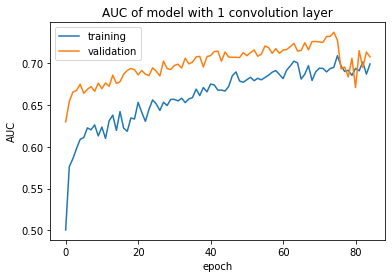

In [ ]:
plt.plot(history1conv.history['auc'])
plt.plot(history1conv.history['val_auc'])
plt.title('AUC of model with 1 convolution layer')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

#Model with 3 convolution layers

In [ ]:
layer_sizes = [64, 64, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh", "tanh"],
    k=35,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Use fn_output_signature instead


In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model3conv = Model(inputs=x_inp, outputs=predictions)

model3conv.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc", "AUC"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model3conv.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 dropout (Dropout)              (None, None, 10)     0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution (GraphConvol  (None, None, 64)    640         ['dropout[0][0]',            

In [ ]:
history3conv = model3conv.fit(
    train_gen, epochs=100, verbose=1, validation_data=valid_gen, shuffle=True, callbacks=[cb])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/sort_pooling/map/while/gradients/model/sort_pooling/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


129/129 [==============================] - 135s 947ms/step - loss: 0.2866 - acc: 0.9387 - auc: 0.4529 - val_loss: 0.1073 - val_acc: 0.9803 - val_auc: 0.5427
Epoch 2/100
129/129 [==============================] - 118s 919ms/step - loss: 0.1739 - acc: 0.9626 - auc: 0.5112 - val_loss: 0.0967 - val_acc: 0.9803 - val_auc: 0.6437
Epoch 3/100
129/129 [==============================] - 116s 901ms/step - loss: 0.1681 - acc: 0.9626 - auc: 0.5340 - val_loss: 0.1027 - val_acc: 0.9803 - val_auc: 0.6466
Epoch 4/100
129/129 [==============================] - 118s 918ms/step - loss: 0.1640 - acc: 0.9626 - auc: 0.5693 - val_loss: 0.1041 - val_acc: 0.9803 - val_auc: 0.6542
Epoch 5/100
129/129 [==============================] - 125s 971ms/step - loss: 0.1637 - acc: 0.9626 - auc: 0.5635 - val_loss: 0.1076 - val_acc: 0.9803 - val_auc: 0.6528
Epoch 6/100
129/129 [==============================] - 124s 966ms/step - loss: 0.1640 - acc: 0.9626 - auc: 0.5594 - val_loss: 0.0989 - val_acc: 0.9803 - val_auc: 0.657

In [ ]:
model3conv.evaluate(valid_gen)

4113/4113 [==============================] - 33s 8ms/step - loss: 0.0923 - acc: 0.9798 - auc: 0.7697


[0.09229346364736557, 0.9798200726509094, 0.7697049975395203]

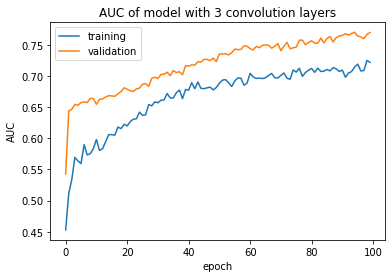

In [ ]:
plt.plot(history3conv.history['auc'])
plt.plot(history3conv.history['val_auc'])
plt.title('AUC of model with 3 convolution layers')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

#Evaluation of the best model on test data

In [ ]:
test_gen = gen.flow(
    list(test_idx),
    targets=dataset.labels[test_idx],
    batch_size=64,
    symmetric_normalization=False,
)

In [ ]:
model3conv.evaluate(test_gen)

65/65 [==============================] - 5s 78ms/step - loss: 0.1234 - acc: 0.9689 - auc: 0.7438


[0.12335515022277832, 0.9688791632652283, 0.7437580227851868]

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('actual label')
  plt.xlabel('predicted label')

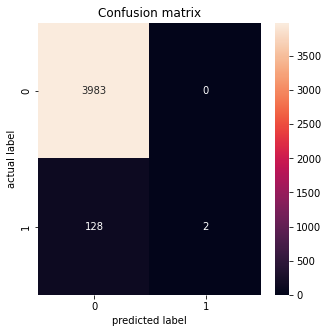

In [ ]:
predictions = model3conv.predict(test_gen)
plot_cm(dataset.labels[test_idx], predictions)

#Training on ballanced data

In [ ]:
pos = dataset.labels[train_idx].sum()
pos

1232

In [ ]:
new_train_idx = np.array([0])
new_train_idx.resize(2 * pos)
new_train_idx.shape

i = 0
neg = 0
for id in train_idx:
  if dataset.labels[id] == 0:
    neg += 1
    if neg > pos:
      continue
  new_train_idx[i] = id
  i += 1

new_train_idx

array([    3,     4,     5, ..., 41093, 41098, 41099])

In [ ]:
train_gen = gen.flow(
    list(new_train_idx),
    targets=dataset.labels[new_train_idx],
    batch_size=64,
    symmetric_normalization=False,
)

In [ ]:
layer_sizes = [64, 64, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh", "tanh"],
    k=35,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [ ]:
model3conv_ballanced = Model(inputs=x_inp, outputs=predictions)

model3conv_ballanced.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc", "AUC"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history3conv_ballanced = model3conv_ballanced.fit(
    train_gen, epochs=100, verbose=1, validation_data=valid_gen, shuffle=True, callbacks=[cb])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/sort_pooling_3/map/while/gradients/model_4/sort_pooling_3/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_4/sort_pooling_3/map/while/gradients/model_4/sort_pooling_3/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/sort_pooling_3/map/while/gradients/model_4/sort_pooling_3/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


39/39 [==============================] - 16s 357ms/step - loss: 0.6701 - acc: 0.6429 - auc: 0.6806 - val_loss: 0.7883 - val_acc: 0.2558 - val_auc: 0.6468
Epoch 2/100
39/39 [==============================] - 13s 343ms/step - loss: 0.6406 - acc: 0.6692 - auc: 0.7120 - val_loss: 0.9098 - val_acc: 0.2567 - val_auc: 0.6431
Epoch 3/100
39/39 [==============================] - 12s 319ms/step - loss: 0.6257 - acc: 0.6814 - auc: 0.7426 - val_loss: 0.9518 - val_acc: 0.2769 - val_auc: 0.6453
Epoch 4/100
39/39 [==============================] - 13s 339ms/step - loss: 0.6114 - acc: 0.6867 - auc: 0.7424 - val_loss: 0.8904 - val_acc: 0.3170 - val_auc: 0.6502
Epoch 5/100
39/39 [==============================] - 13s 344ms/step - loss: 0.6067 - acc: 0.6806 - auc: 0.7382 - val_loss: 0.9873 - val_acc: 0.2691 - val_auc: 0.6442
Epoch 6/100
39/39 [==============================] - 12s 321ms/step - loss: 0.5977 - acc: 0.6879 - auc: 0.7478 - val_loss: 1.0037 - val_acc: 0.2599 - val_auc: 0.6397
Epoch 7/100
39/3

In [ ]:
model3conv_ballanced.evaluate(valid_gen)

4113/4113 [==============================] - 13s 3ms/step - loss: 0.8904 - acc: 0.3170 - auc: 0.6502


[0.8903762698173523, 0.3170435130596161, 0.6502363681793213]